In [ ]:
!pip install imbalanced-learn

# Load Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from imblearn.over_sampling import SMOTE

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ludocielbeckett/health-risk-prediction-anonymized-real-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ludocielbeckett/health-risk-prediction-anonymized-real-data/versions/1


| Category        | Temperature Range (°F) | Meaning             |
| --------------- | ---------------------- | ------------------- |
| High Risk (Low) | <95.0                  | Hypothermia         |
| Low Risk        | 97.0 – 99.5            | Normal              |
| Medium Risk     | 99.6 – 102.9           | Mild–Moderate Fever |
| High Risk       | ≥103.0                 | High Fever          |


In [ ]:
csv_files = glob.glob(path + "/*.csv")
print("CSV files found:", csv_files)

df = pd.read_csv(csv_files[0])
df.head()

CSV files found: ['/root/.cache/kagglehub/datasets/ludocielbeckett/health-risk-prediction-anonymized-real-data/versions/1/Health_Risk_Dataset.csv']


,Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Risk_Level
0,P0522,25,96,1,97,107,37.5,A,0,Medium
1,P0738,28,92,2,116,151,38.5,P,1,High
2,P0741,29,91,1,79,135,38.4,A,0,High
3,P0661,24,96,1,95,92,37.3,A,0,Medium
4,P0412,20,96,1,97,97,37.4,A,0,Low


# Data Cleaning & Feature Engineering

In [ ]:
# Remove Unwanted Columns
new_df = df.drop(["Patient_ID", "Respiratory_Rate", "Oxygen_Saturation", "O2_Scale", "Systolic_BP", "Heart_Rate", "Consciousness", "On_Oxygen"], axis=1)
new_df.head()

,Temperature,Risk_Level
0,37.5,Medium
1,38.5,High
2,38.4,High
3,37.3,Medium
4,37.4,Low


In [ ]:
# Convert Celsius Temperatures to Fahrenheit
for i, row in new_df.iterrows():
    new_df.at[i, "Temperature"] = (row["Temperature"] * 9/5) + 32

new_df.head()

,Temperature,Risk_Level
0,99.50,Medium
1,101.30,High
2,101.12,High
3,99.14,Medium
4,99.32,Low


| Category        | Temperature Range (°F) | Meaning             |
| --------------- | ---------------------- | ------------------- |
| High Risk (Low) | <95.0                  | Hypothermia         |
| Low Risk        | 95.0 – 99.5            | Normal              |
| Medium Risk     | 99.6 – 102.9           | Mild–Moderate Fever |
| High Risk       | ≥103.0                 | High Fever          |

In [ ]:
# Replace Incorrect Labels With Correct Labels
for i, row in new_df.iterrows():
  label = ""
  if row["Temperature"] < 95:
    label = "Low (High)"
  elif row["Temperature"] >= 95 and row["Temperature"] <= 99.5:
    label = "Low"
  elif row["Temperature"] >= 99.6 and row["Temperature"] <= 102.9:
    label = "Medium"
  elif row["Temperature"] >= 103:
    label = "High"

  new_df.at[i, "Risk_Level"] = label

new_df.head()

,Temperature,Risk_Level
0,99.50,Low
1,101.30,Medium
2,101.12,Medium
3,99.14,Low
4,99.32,Low


In [ ]:
# Check For Null Values
new_df["Risk_Level"].value_counts()

,count
Risk_Level,
Medium,458
Low,430
High,108
,4


In [ ]:
# Remove Null Values
for i, row in new_df.iterrows():
  if row["Risk_Level"] == "":
    new_df.drop(i, inplace=True)

new_df["Risk_Level"].value_counts()

,count
Risk_Level,
Medium,458
Low,430
High,108


In [ ]:
# Add Hypothermia Synthetic Data
synthetic_samples = {"Temperature": [] ,"Risk_Level": []}

for i in range(250):
  temp = np.random.uniform(0, 94.99)
  synthetic_samples["Temperature"].append(temp)
  synthetic_samples["Risk_Level"].append("Low (High)")

new_samples_df = pd.DataFrame(synthetic_samples)

new_df = pd.concat([new_df, new_samples_df], ignore_index=True)
new_df

,Temperature,Risk_Level
0,99.500000,Low
1,101.300000,Medium
2,101.120000,Medium
3,99.140000,Low
4,99.320000,Low
...,...,...
1241,94.119692,Low (High)
1242,44.038336,Low (High)
1243,85.290832,Low (High)
1244,59.640087,Low (High)


<Axes: xlabel='Risk_Level'>

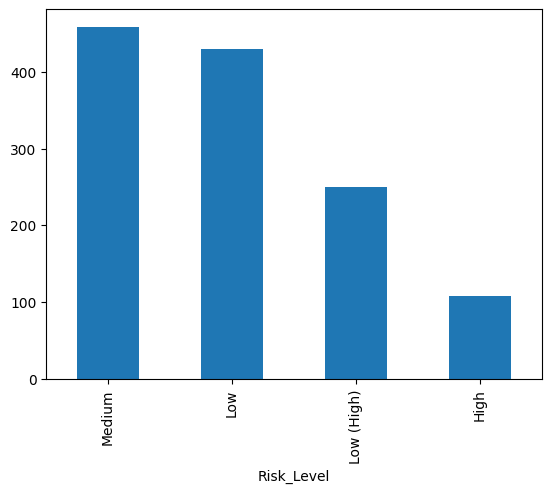

In [ ]:
# Sample Distribution Before
new_df["Risk_Level"].value_counts().plot.bar()

In [ ]:
# Seperate Input from Label Data
X = new_df.drop("Risk_Level", axis=1)
y = new_df["Risk_Level"]

print(X.head())
print("-" * 50)
print(y.head())

   Temperature
0        99.50
1       101.30
2       101.12
3        99.14
4        99.32
--------------------------------------------------
0       Low
1    Medium
2    Medium
3       Low
4       Low
Name: Risk_Level, dtype: object


In [ ]:
# Oversample Distribution With Synthetic Data To Create An Even Distribution
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

<Axes: xlabel='Risk_Level'>

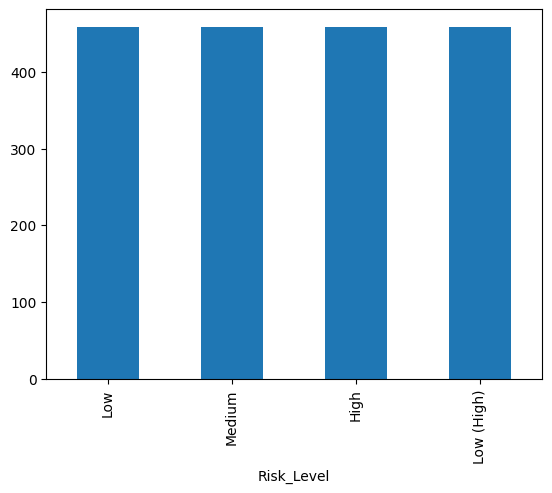

In [ ]:
# Sample Distribution after resampling
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
resampled_df["Risk_Level"].value_counts().plot.bar()

## Visualize Temperature Distribution


The generated violin plot visualizes the spread and central tendency of temperature for each risk level. It allows for a clear understanding of how temperature values are distributed within the 'High', 'Medium', and 'Low' risk categories, enabling visual comparison of their ranges, density, and median temperatures.



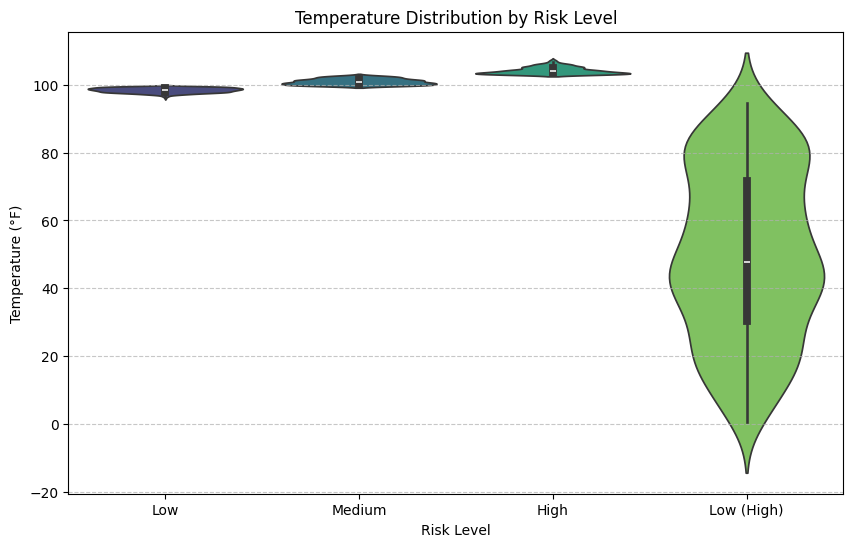

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Risk_Level', y='Temperature', data=resampled_df, palette='viridis', hue='Risk_Level', legend=False)
plt.title('Temperature Distribution by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Temperature (°F)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-2214088587.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resampled_df['Temperature'])


<Axes: xlabel='Temperature', ylabel='Density'>

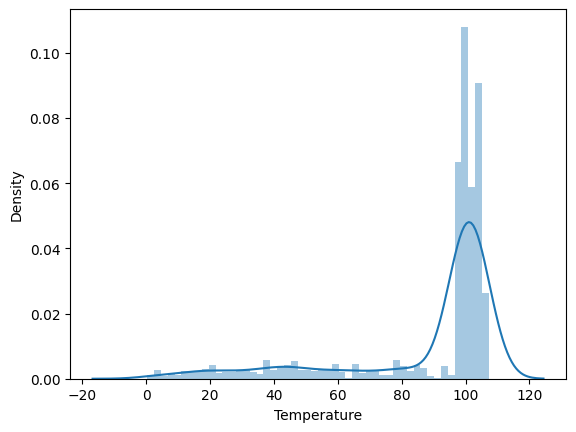

In [ ]:
# Plot a histogram of temperatures together with a smooth distribution of that histogram overlaid on it.
sns.distplot(resampled_df['Temperature'])

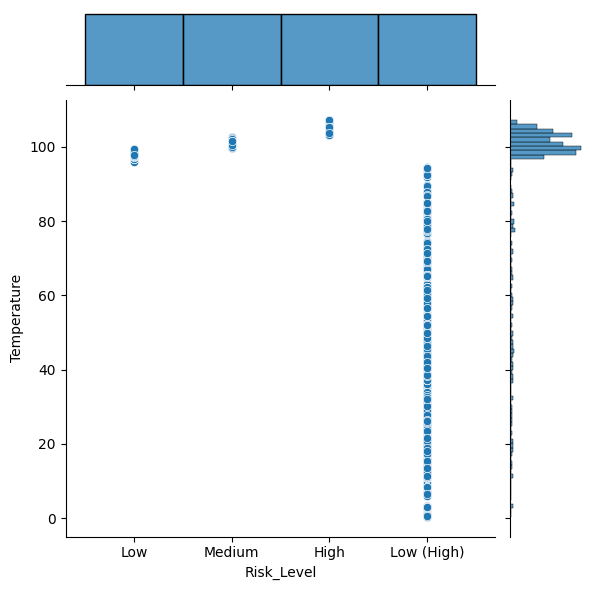

In [ ]:
# Most common Risk_Level - Temperature Configuration
sns.jointplot(x='Risk_Level', y="Temperature", data=resampled_df)

In [ ]:
# Make First split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled)

# Make Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

# Output shapes
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1323, 1) (1323,) (234, 1) (234,) (275, 1) (275,)


In [ ]:
# Create classifier
log_reg = LogisticRegression(random_state=42, max_iter=1000)

In [ ]:
# Train model
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)


Train Accuracy: 99.32%

Validation Accuracy: 98.72%

Validation Classification Report:
              precision    recall  f1-score   support

        High       0.95      1.00      0.97        58
         Low       1.00      1.00      1.00        59
  Low (High)       1.00      1.00      1.00        58
      Medium       1.00      0.95      0.97        59

    accuracy                           0.99       234
   macro avg       0.99      0.99      0.99       234
weighted avg       0.99      0.99      0.99       234

Test Accuracy: 99.64%

Test Classification Report:
              precision    recall  f1-score   support

        High       0.99      1.00      0.99        69
         Low       1.00      1.00      1.00        68
  Low (High)       1.00      1.00      1.00        69
      Medium       1.00      0.99      0.99        69

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00   

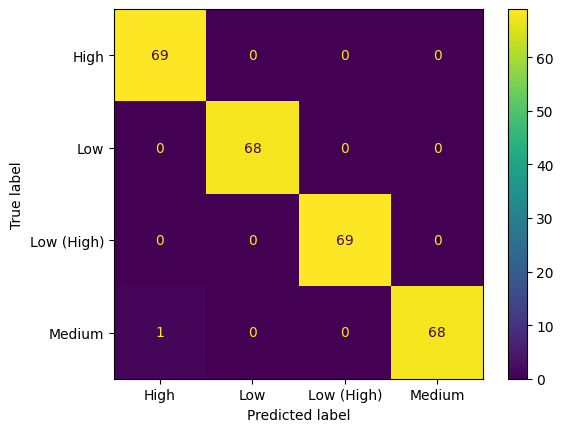

In [ ]:
# Get train accuracy
train_acc = log_reg.score(X_train, y_train)
print(f"\nTrain Accuracy: {train_acc*100:.2f}%")

# Evaluate model and get validation accuracy
val_predictions = log_reg.predict(X_val)
val_acc = accuracy_score(y_val, val_predictions)
print(f"\nValidation Accuracy: {val_acc*100:.2f}%")

# Display validation metrics
print("\nValidation Classification Report:")
print(classification_report(y_val, val_predictions))

# Test model and get test accuracy
y_pred = log_reg.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Display test metrics
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred))

# Display model's TP,FP,TN,FN predictions
print("\nConfusion Matrix:")
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))